# 1. Import libraries

In [1]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.5  Python-3.12.2 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Setup complete  (12 CPUs, 15.8 GB RAM, 188.0/237.8 GB disk)


In [4]:
import os
import shutil
import yaml
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

# 2. Extract Data from XML and store in YOLOv8 format

In [5]:
def extract_data_from_xml(root_dir):
    xml_path = os.path.join(root_dir, 'words.xml')
    # Parse file xml
    tree = ET.parse(xml_path)
    # Đọc thẻ root của file
    root = tree.getroot()

    # Khai bao cac list rong de luu tru du lieu
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    # Duyet qua tung the anh <image>
    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # Bo qua truong hop label khoong phai ky tu alphabet hoac so
                if not bb[0].text.isalnum():
                    continue

                # Bo qua truong hop label la cac ky tu khong thuoc unicode
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                # Dua thong tin toa do bbox vao list bbs_of_img
                # format bbox: (xmin, ymin, bbox_width, bbox_height)
                bbs_of_img.append(
                    [
                        float(bb.attrib['x']),
                        float(bb.attrib['y']),
                        float(bb.attrib['width']),
                        float(bb.attrib['height'])
                    ]
                )
                # Dua label vao list labels_of_img
                labels_of_img.append(bb[0].text.lower())

        # Dua thong tin path img dang xet vao list img_paths
        img_paths.append(os.path.join(root_dir, img[0].text))
        # Dua thong tin img resolution vao list img_sizes
        img_sizes.append(
            (
                int(img[1].attrib['x']),
                int(img[1].attrib['y'])
            )
        )
        # Dua list bbox vao list bboxes
        bboxes.append(bbs_of_img)
        # Dua list labels vaoo list img_labels
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [6]:
os.chdir(f'{os.getcwd()}\\icdar2003\\SceneTrialTrain')

In [7]:
# Thuc hien loi goi ham extract_data_from_xml
dataset_dir = os.getcwd()
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

In [8]:
print(bboxes[1])

[[432.0, 635.0, 847.0, 172.0]]


In [9]:
print(f"Total image: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total image: 250
Total bounding boxes: 1097


# 3. Convert to YOLOv8 format

In [10]:
def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    """
    Thực hiện normalize bounding box

    Parameters:
        image_paths (list): Danh sách chứa các path ảnh;
        image_sizes (list): Danh sách chứa độ phân giải ảnh;
        bounding_boxes (list): Danh sách chứa danh sách bbox.

    Returns:
        yolov8_data (list): Danh sách gồm (image_path, image_size, bboxes)
    """
    # Khai bao list rong de chua ket qua
    yolov8_data = []

    # Duyet qua tung bo path, resolution va bboxes anh.
    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        # Khai baoo list rong de chua label (format yolov8)
        yolov8_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Current format: (x_min, y_min, width, height)
            # New format: (x_center, y_center, width, height)
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Ma class, mac dinh = 0 vi chi co 1 class 'text'
            class_id = 0

            # Doi format label
            # Format: "class_id x_center y_center width height"
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data

In [11]:
# Dinh nghia class
class_labels = ['text']

# Thuc hien loi goi ham
yolov8_data = convert_to_yolov8_format(
    img_paths,
    img_sizes,
    bboxes
)

In [12]:
yolov8_data

[('C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\SceneTrialTrain\\apanar_06.08.2002/IMG_1261.JPG',
  ['0 0.194375 0.40791666666666665 0.17125 0.1625',
   '0 0.5321875 0.40208333333333335 0.424375 0.1525',
   '0 0.309375 0.5825 0.38875 0.145',
   '0 0.67875 0.5770833333333333 0.27875 0.15583333333333332',
   '0 0.0746875 0.04125 0.059375 0.0725',
   '0 0.2159375 0.03833333333333333 0.123125 0.07333333333333333',
   '0 0.5309375 0.03375 0.071875 0.0675',
   '0 0.19625 0.7645833333333333 0.1425 0.11583333333333333',
   '0 0.3471875 0.7770833333333333 0.103125 0.09083333333333334',
   '0 0.4496875 0.7758333333333334 0.044375 0.08833333333333333',
   '0 0.571875 0.7620833333333333 0.13625 0.1175']),
 ('C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\SceneTrialTrain\\apanar_06.08.2002/IMG_1263.JPG',
  ['0 0.5346875 0.6008333333333333 0.529375 0.14333333333333334']),
 ('C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\SceneTrialTrain\\apanar_06.08.2002/IMG_1265.JPG',
  [

# 4. Train, val, test split

In [13]:
seed = 0
val_size = 0.2
test_size = 0.125

train_data, test_data = train_test_split(
    yolov8_data,
    test_size = val_size,
    random_state = seed,
    shuffle=True
)

test_data, val_data = train_test_split(
    test_data,
    test_size = test_size,
    random_state = seed,
    shuffle = True
)

In [14]:
print(f'Train size: {len(train_data)}')
print(f'Val size: {len(val_data)}')
print(f'Test size: {len(test_data)}')

Train size: 200
Val size: 7
Test size: 43


# 5. Save data

In [15]:
def save_data(data, src_img_dir, save_dir):
    """
    Xay dung thu muc chua du lieu theo format YOLO

    Parameters:
        data (list): Danh sach chua thong tin label anh;
        src_img_dir (str): Path den thu muc du lieu goc;
        save_dir (str): Path den thu muc du lieu moi.
    """
    # Tao thu muc moi neu chua co
    os.makedirs(save_dir, exist_ok=True)

    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    for image_path, yolov8_labels in data:
        # Copy anh tu thu muc goc sang thu muc "images"
        shutil.copy(
            os.path.join(src_img_dir, image_path),
            os.path.join(save_dir, "images")
        )

        # Ghi noi dung label vao file image_name.txt o thu muc "labels"
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f'{label}\n')

In [16]:
save_yolo_data_dir = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(
    save_yolo_data_dir,
    'train'
)
save_val_dir = os.path.join(
    save_yolo_data_dir,
    'val'
)
save_test_dir = os.path.join(
    save_yolo_data_dir,
    'test'
)

save_data(
    train_data,
    dataset_dir,
    save_train_dir)
save_data(
    test_data,
    dataset_dir,
    save_val_dir)
save_data(
    val_data,
    dataset_dir,
    save_test_dir)

# 6. Create yaml file

In [17]:
data_yaml = {
    'path': 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\yolo_data',
    'train': 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\yolo_data\\train\\images',
    'test': 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\yolo_data\\test\\images',
    'val': 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\yolo_data\\val\\images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)

with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

# 7. Training

In [18]:
from ultralytics import YOLO

# load a model
model = YOLO('yolov8s.yaml').load('yolov8s.pt')
#model.to('cuda')

# Train the model
epochs = 200
imgsz = 1024
results = model.train(
    data = yolo_yaml_path,
    epochs = epochs,
    imgsz = imgsz,
    project = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\models',
    name = 'yolov8\\detect\\train'
)

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.2.5  Python-3.12.2 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.yaml, data=C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\icdar2003\yolo_data\data.yml, epochs=200, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\models, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

train: Scanning C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\icdar2003\yolo_data\train\labels.cache... 200 images, 7 backgrou
val: Scanning C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\icdar2003\yolo_data\val\labels.cache... 43 images, 2 backgrounds, 


Plotting labels to C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\models\yolov8\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\models\yolov8\detect\train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200       9.5G       2.01       5.35      1.794         87       1024: 100%|██████████| 13/13 [01:34<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         43        200      0.312      0.425      0.287      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200       9.7G      1.131      1.765      1.182         73       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.631      0.785      0.738      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      9.77G      1.097      1.328      1.149         57       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.705       0.73      0.707      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      9.78G      1.143       1.38      1.168         94       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.384      0.655      0.398        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       9.8G       1.18       1.26      1.188         55       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.515       0.74       0.54      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      9.79G      1.184      1.291      1.255         26       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.384       0.54      0.331      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      9.81G      1.188      1.109      1.205         61       1024: 100%|██████████| 13/13 [01:30<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.311       0.61       0.36      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      9.58G      1.218      1.114      1.211         58       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.678      0.705      0.712      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      9.77G      1.199      1.128      1.197         84       1024: 100%|██████████| 13/13 [01:32<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.759       0.53      0.616      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      9.79G      1.212      1.117      1.218         74       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.546      0.365      0.402      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200       9.8G      1.144      1.021      1.177         53       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.599       0.49      0.525      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      9.82G      1.187      1.035      1.206         42       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.311      0.365      0.299      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      9.71G       1.16      1.073      1.186         57       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.681      0.535       0.56      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      9.79G      1.153      1.019      1.216         49       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.738       0.72      0.745      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      9.75G      1.144      1.049       1.17         72       1024: 100%|██████████| 13/13 [01:39<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.767       0.61      0.688      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      9.79G      1.132      1.036      1.182         56       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.699      0.775      0.742      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      9.59G      1.093     0.9146      1.148         70       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.736      0.753      0.784      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      9.78G      1.106     0.9097      1.176         62       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.837      0.825      0.851      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      9.79G      1.082     0.8919      1.153         45       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.804       0.85       0.86      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      9.61G      1.107     0.9171      1.146         78       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.822       0.82      0.832      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      9.61G      1.013     0.8459      1.116         78       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.812      0.835      0.853      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      9.72G      1.023      0.827      1.097         70       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.857      0.779      0.851      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      9.79G      1.039     0.8436      1.137         51       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.851      0.755      0.832       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      9.83G      1.048     0.8681      1.118        108       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.778       0.87      0.857       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      9.59G          1     0.8133      1.099         53       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.809      0.892      0.853      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      9.62G     0.9974     0.7947      1.087         53       1024: 100%|██████████| 13/13 [01:20<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.835      0.825      0.823      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      9.62G      0.989     0.7885      1.082         27       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.839       0.79      0.848      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       9.8G      1.014     0.8723      1.136         56       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.722       0.75      0.785      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      9.81G     0.9867     0.7963      1.084         48       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.819      0.817      0.844      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      9.81G     0.9783     0.8055      1.089         71       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.822      0.831      0.862      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      9.63G     0.9618     0.8169      1.133         32       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.816      0.819      0.858       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      9.62G     0.9741     0.8076      1.093         61       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.762       0.89      0.844      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200       9.8G     0.9108     0.7452      1.054         74       1024: 100%|██████████| 13/13 [01:31<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.847      0.895      0.889      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      9.79G     0.9346     0.7513      1.067         46       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0


                   all         43        200      0.878      0.875      0.889      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       9.8G     0.9468     0.7404      1.069         40       1024: 100%|██████████| 13/13 [01:31<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.809      0.892      0.859      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      9.82G     0.9367     0.7656      1.066         85       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.815      0.883      0.877      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200       9.8G     0.9123     0.7556      1.068         47       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.813       0.85      0.843      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      9.83G     0.9343      0.752      1.095         45       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.819       0.81      0.857      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      9.51G     0.8967     0.7449       1.07         83       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.792      0.878      0.867      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      9.86G     0.8899      0.731      1.061         65       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.896      0.859      0.908      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      9.58G     0.8945     0.7042      1.035         57       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200       0.84      0.894      0.909      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      9.77G     0.9123     0.7371      1.053         74       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.854      0.885       0.91      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      9.84G     0.8959     0.7033      1.049         40       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.859      0.887      0.903      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      9.63G     0.8964     0.6699      1.046         60       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.863      0.819      0.878       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      9.76G     0.9034     0.6935      1.047         67       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.872      0.888      0.895      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      9.87G      0.905     0.6646      1.038         57       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.842       0.88      0.862      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      9.79G     0.8806     0.6845       1.04         66       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.837      0.905      0.907      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200       9.8G     0.8932     0.6686      1.038         63       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.869       0.88      0.897      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      9.83G     0.8875     0.6522      1.021         58       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.863      0.855       0.88      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      9.71G     0.8738     0.6502      1.053         55       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200       0.85      0.881       0.89      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      9.83G     0.8331     0.6196      1.032         64       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.851      0.885      0.896      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      9.61G     0.8701     0.6579      1.036         63       1024: 100%|██████████| 13/13 [01:20<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.836       0.89      0.895      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200       9.6G     0.7927     0.6154      1.005         55       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.847       0.86      0.881      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      9.62G     0.8739     0.6817      1.027         54       1024: 100%|██████████| 13/13 [01:31<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.855       0.88      0.902      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      9.85G     0.8508     0.6409      1.008         65       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.844       0.87      0.861      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      9.79G      0.867     0.6756      1.024         31       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.902       0.86      0.904      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      9.77G     0.8601     0.6449      1.021         58       1024: 100%|██████████| 13/13 [01:32<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.849       0.86      0.898      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      9.61G     0.8252     0.6007     0.9867         68       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.821       0.86      0.858      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      9.53G     0.8269     0.6286      1.006         60       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200       0.84       0.84      0.874      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      9.62G      0.817       0.59      1.003         47       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.895      0.875      0.899      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      9.76G     0.8069      0.596     0.9999         45       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.865       0.88      0.899      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      9.64G     0.7844     0.6062      1.004         70       1024: 100%|██████████| 13/13 [01:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.872      0.845      0.882      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      9.81G     0.8251     0.5962      1.014         38       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200       0.91      0.845      0.909      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      9.79G     0.7904     0.5844     0.9971         43       1024: 100%|██████████| 13/13 [01:20<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.884      0.836      0.891      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200       9.8G     0.8024     0.5935      1.016         47       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.879      0.872      0.903      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      9.61G     0.8056     0.5929      1.007         46       1024: 100%|██████████| 13/13 [01:16<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.837      0.898      0.894      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200       9.8G     0.8182     0.5789     0.9802         83       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.818      0.925      0.882      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      9.62G     0.8147     0.5925      1.023         62       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.883      0.903      0.885       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      9.62G     0.8122     0.5814      1.018         61       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.869      0.925      0.902      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200       9.8G     0.7949     0.5817       1.01         41       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.859      0.925      0.919      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       9.8G     0.8253     0.5803     0.9936         55       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.894       0.89      0.924      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      9.62G     0.7976     0.5737     0.9975         52       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.887      0.865      0.889      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      9.77G     0.7754     0.5749     0.9957         58       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.894      0.846      0.898      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      9.73G     0.7807     0.5799      1.004         45       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.933      0.832      0.923      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      9.65G     0.7275     0.5358     0.9732         48       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.872       0.87      0.922      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      9.81G     0.7747     0.5762     0.9806         57       1024: 100%|██████████| 13/13 [01:33<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.857      0.839      0.896      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200       9.7G     0.7488     0.5368      0.973         71       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.844      0.895      0.883      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      9.52G     0.8042      0.576      1.015         67       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.869      0.905      0.901       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       9.8G     0.7885     0.5529      1.003         69       1024: 100%|██████████| 13/13 [01:32<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.895      0.893      0.915      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      9.62G     0.7966     0.5653      1.002         34       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.885      0.886      0.913      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      9.82G     0.7975     0.5783       1.01         46       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.918       0.88      0.909       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      9.79G     0.7843      0.556     0.9787         78       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.862      0.865      0.887      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      9.63G     0.7493     0.5596     0.9715         45       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.887       0.85       0.88      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      9.83G     0.7556     0.5925     0.9852         27       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.816       0.86      0.866      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      9.57G     0.7494     0.5372     0.9712         49       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.873      0.827      0.891      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       9.6G     0.7445     0.5433     0.9619         65       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.892      0.815      0.894      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      9.81G     0.7279     0.5205     0.9574         49       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.882       0.86      0.899      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      9.45G     0.7109     0.5175      0.952         79       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.876        0.9      0.901      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      9.76G     0.7272     0.5243     0.9689         52       1024: 100%|██████████| 13/13 [01:20<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.907       0.88      0.912      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      9.58G     0.7075     0.4858     0.9524         70       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.896      0.902      0.908      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      9.58G     0.7215     0.5083     0.9702         59       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.923       0.87      0.905      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      9.79G     0.7201     0.5267      0.962         62       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.919       0.85      0.918      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      9.41G     0.7184     0.5123      0.951         83       1024: 100%|██████████| 13/13 [01:15<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<0

                   all         43        200      0.913        0.9      0.926      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      9.78G     0.7256     0.4998      0.955         66       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.893      0.895       0.92      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      9.83G      0.719     0.4977     0.9592         68       1024: 100%|██████████| 13/13 [01:33<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.876      0.851       0.89      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      9.81G     0.7113     0.5082     0.9643         66       1024: 100%|██████████| 13/13 [01:31<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.915       0.86      0.908      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      9.59G     0.6893     0.4933     0.9618         71       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.911      0.873      0.907      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      9.73G       0.66     0.4695     0.9519         76       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200        0.9       0.89      0.922      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      9.83G     0.7032     0.4836     0.9542        113       1024: 100%|██████████| 13/13 [01:31<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.908      0.893      0.924      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      9.62G     0.6713     0.4849      0.953         90       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.914      0.855      0.915       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      9.82G     0.7071     0.4949     0.9537         53       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.882       0.91      0.915      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       9.6G     0.6782     0.4859     0.9459         61       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.916      0.869      0.913      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      9.73G     0.6904     0.4936     0.9634         30       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.891        0.9      0.919      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200       9.8G     0.6883     0.4791     0.9439         48       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.915       0.87      0.917      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200       9.7G     0.6952     0.4972     0.9613         52       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.895      0.885      0.922       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      9.83G     0.6791     0.4721     0.9488         56       1024: 100%|██████████| 13/13 [01:33<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.909       0.89       0.93      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      9.78G     0.6469      0.468     0.9352         70       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.873      0.895      0.913      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      9.62G     0.6862     0.4804     0.9524         36       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.894      0.889      0.923        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      9.78G     0.6341     0.4633     0.9216         70       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200       0.86       0.92       0.91      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      9.81G      0.655     0.4554     0.9438         58       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.861      0.901      0.904      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      9.85G     0.6919     0.4834     0.9533         88       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.893      0.875      0.916      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      9.82G     0.6702     0.4765      0.952         43       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.875      0.913      0.909       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      9.79G     0.6991     0.4791     0.9535         23       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.889       0.91      0.905      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200       9.8G     0.6443     0.4598     0.9288         40       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.931      0.875      0.922      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      9.61G     0.6382     0.4474     0.9381         47       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.905      0.902       0.92      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      9.79G     0.6643     0.4639     0.9343         46       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.916       0.89      0.916      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      9.55G     0.6574      0.457      0.919         65       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.918      0.894      0.929      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      9.57G     0.6424     0.4435     0.9299         70       1024: 100%|██████████| 13/13 [01:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.918      0.895      0.926       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      9.65G     0.6685      0.458     0.9451         73       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.898      0.895      0.918      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      9.64G     0.6636      0.459     0.9386         46       1024: 100%|██████████| 13/13 [01:18<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.888       0.93       0.93      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      9.76G     0.6328     0.4358     0.9254         69       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200       0.88      0.915      0.926      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      9.48G     0.6523     0.4413     0.9359        155       1024: 100%|██████████| 13/13 [01:19<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<0

                   all         43        200      0.897       0.92      0.916      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      9.73G       0.66     0.4519     0.9409         47       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.895      0.895      0.922       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      9.78G     0.6378     0.4375     0.9337         60       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.873       0.92      0.917      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      9.58G     0.6339     0.4328      0.925         78       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.889       0.91      0.927      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      9.61G      0.627     0.4272     0.9295        100       1024: 100%|██████████| 13/13 [01:17<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.871      0.905      0.924      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      9.81G     0.6284     0.4447     0.9237         69       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.916      0.878      0.923      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      9.73G     0.6302     0.4388      0.937         43       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.886      0.858      0.899      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      9.58G      0.598     0.4229     0.9249         77       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.876      0.845      0.885      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200       9.8G     0.6026     0.4385     0.9151         46       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.893       0.89      0.916      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200       9.6G     0.5922      0.407     0.9254         54       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200       0.93      0.868      0.921      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      9.78G     0.6273     0.4231      0.918         64       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.897      0.895      0.908      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      9.77G     0.6326     0.4417     0.9349        104       1024: 100%|██████████| 13/13 [01:30<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200       0.91      0.885      0.916      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      9.62G     0.6061      0.419     0.9139         48       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.866      0.904      0.917      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      9.75G      0.605     0.4183     0.9194         72       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.867       0.92      0.918      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200       9.8G     0.6173     0.4116     0.9216         54       1024: 100%|██████████| 13/13 [01:31<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.909      0.895      0.919      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200       9.7G     0.5897     0.4129     0.9229         61       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200       0.92      0.885      0.915      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      9.81G     0.6054     0.4085     0.9168         45       1024: 100%|██████████| 13/13 [01:30<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.931      0.895      0.931      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      9.84G     0.5857     0.3946     0.9078         45       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.926       0.92      0.931      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      9.83G     0.5966     0.4029     0.9183         63       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.914      0.925      0.925      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200       9.7G     0.5793     0.3978     0.9136         73       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.919      0.905      0.922      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      9.72G     0.6071     0.4123     0.9137         64       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.917       0.89      0.911      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      9.85G     0.5841     0.4017     0.9194         40       1024: 100%|██████████| 13/13 [01:30<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.888       0.91      0.916      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      9.85G      0.593     0.4037     0.9056         54       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.902      0.905      0.915      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      9.79G     0.5853     0.3939     0.9102         63       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.908      0.925      0.921       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      9.74G     0.5542     0.3778      0.894         60       1024: 100%|██████████| 13/13 [01:15<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.908        0.9      0.915      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      9.62G     0.5597     0.3768     0.9015         68       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.907      0.878      0.911       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      9.85G     0.5666     0.3861     0.9179         62       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200        0.9      0.897       0.92      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      9.83G     0.5537     0.3766      0.896         65       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.876      0.885      0.909      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      9.85G      0.553     0.3741      0.902         64       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.913      0.841      0.913      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      9.86G     0.5376     0.3801     0.8906         68       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.887      0.901      0.918      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      9.79G     0.5402     0.3896     0.9222         35       1024: 100%|██████████| 13/13 [01:20<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.902        0.9      0.919      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      9.71G     0.5502     0.3835     0.9011         40       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.933       0.86      0.913      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200       9.8G     0.5439      0.374     0.8983         66       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.931       0.88      0.915      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      9.61G     0.5561     0.3872     0.9058         51       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200       0.93      0.869      0.913      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      9.81G     0.5452     0.3775     0.9142         55       1024: 100%|██████████| 13/13 [01:30<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.887      0.895      0.913       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      9.48G      0.532     0.3684     0.8955         39       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.898      0.885      0.918      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      9.78G      0.547     0.3849      0.912         91       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.903      0.889      0.921      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      9.46G     0.5416     0.3721      0.915         41       1024: 100%|██████████| 13/13 [01:21<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.927      0.888      0.925       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      9.72G     0.5282     0.3752     0.8949         52       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200       0.91      0.906      0.926      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      9.76G      0.558     0.3816      0.893         98       1024: 100%|██████████| 13/13 [01:24<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.906       0.88      0.924      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      9.79G     0.5533     0.3779     0.8881         82       1024: 100%|██████████| 13/13 [01:36<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.913       0.89      0.923      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      9.47G      0.547     0.3737     0.8991         82       1024: 100%|██████████| 13/13 [01:22<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200       0.93      0.865      0.915      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      9.85G     0.5359     0.3658     0.8946         61       1024: 100%|██████████| 13/13 [01:30<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.936      0.845      0.916      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      9.79G     0.5216      0.349     0.8928         57       1024: 100%|██████████| 13/13 [01:26<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.917       0.87      0.919      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      9.79G     0.5318     0.3709     0.9057         67       1024: 100%|██████████| 13/13 [01:23<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.895      0.905      0.923      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      9.81G      0.533     0.3756     0.9005         53       1024: 100%|██████████| 13/13 [01:31<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.908      0.893      0.922      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      9.73G     0.5276     0.3592     0.8816         37       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.905      0.905      0.921      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      9.75G     0.5264      0.361     0.8831         64       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.912      0.895      0.918      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      9.48G     0.5423     0.3568     0.8953        119       1024: 100%|██████████| 13/13 [01:20<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200       0.92      0.875      0.917      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       9.8G     0.5211     0.3605     0.8878         56       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.916      0.895       0.92       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      9.62G     0.5227      0.361     0.8864         53       1024: 100%|██████████| 13/13 [01:25<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.913       0.89      0.918       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      9.44G     0.5121     0.3537     0.8914         51       1024: 100%|██████████| 13/13 [01:29<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.896      0.907      0.916       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200       9.8G     0.4935     0.3421     0.8794         52       1024: 100%|██████████| 13/13 [01:36<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.884      0.911      0.915      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      9.64G     0.5158     0.3503     0.8851         46       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.894      0.875      0.913      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      9.73G     0.5002     0.3429     0.8775         52       1024: 100%|██████████| 13/13 [01:51<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200       0.88      0.895      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      9.57G      0.521     0.3533      0.887         83       1024: 100%|██████████| 13/13 [01:30<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.888      0.907      0.922      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      9.78G     0.5244     0.3549     0.8995         62       1024: 100%|██████████| 13/13 [01:55<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.891      0.902      0.924      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      9.73G     0.5094      0.345     0.8877         48       1024: 100%|██████████| 13/13 [01:47<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<0

                   all         43        200      0.911      0.885      0.924      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      9.66G     0.5008      0.349     0.8878         38       1024: 100%|██████████| 13/13 [01:48<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.877      0.925      0.919      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      9.81G     0.4972     0.3388     0.8872         45       1024: 100%|██████████| 13/13 [01:43<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.877      0.923      0.922       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      9.58G     0.5173     0.3525     0.8908         57       1024: 100%|██████████| 13/13 [01:27<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.897      0.914      0.922      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200       9.8G     0.4982     0.3446     0.8809         50       1024: 100%|██████████| 13/13 [01:37<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.897      0.915      0.918      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200       9.8G     0.4932     0.3458     0.8945         62       1024: 100%|██████████| 13/13 [01:41<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200       0.91      0.905      0.917      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      9.77G     0.5075     0.3453     0.8766         45       1024: 100%|██████████| 13/13 [01:35<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.905      0.908      0.917      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      9.64G     0.4997     0.3368     0.8878         46       1024: 100%|██████████| 13/13 [01:38<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.901      0.895      0.919      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      9.86G     0.4602     0.3226     0.8729         54       1024: 100%|██████████| 13/13 [01:50<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.917      0.884      0.918      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      9.79G     0.4968     0.3355     0.8876         70       1024: 100%|██████████| 13/13 [01:36<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.922       0.89      0.918      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      9.83G     0.4843      0.329     0.8899         60       1024: 100%|██████████| 13/13 [01:43<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.919       0.89      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      9.81G     0.4803     0.3308     0.8667         76       1024: 100%|██████████| 13/13 [01:39<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.879      0.915      0.923      0.731


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      8.86G     0.4694     0.3377     0.8538         53       1024: 100%|██████████| 13/13 [01:31<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0


                   all         43        200      0.899        0.9      0.923      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      8.88G     0.4787      0.336     0.8604         20       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.917      0.885      0.922      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200       8.9G     0.4617     0.3195     0.8335         16       1024: 100%|██████████| 13/13 [01:37<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.909      0.896      0.923      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      8.89G     0.4552     0.3209     0.8541         19       1024: 100%|██████████| 13/13 [01:35<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0


                   all         43        200      0.913      0.905      0.923      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      8.89G     0.4472     0.3158     0.8469         70       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.916      0.905      0.924      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      8.92G      0.428     0.3125     0.8609         19       1024: 100%|██████████| 13/13 [01:30<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.909      0.901      0.925      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      8.91G     0.4343     0.3111      0.833         35       1024: 100%|██████████| 13/13 [01:37<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.916      0.895      0.926      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200       8.9G     0.4409     0.3107     0.8585         22       1024: 100%|██████████| 13/13 [01:34<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         43        200      0.914       0.89      0.926      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      8.91G     0.4528     0.3239     0.8518         44       1024: 100%|██████████| 13/13 [01:28<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         43        200      0.909      0.899      0.926      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      8.94G     0.4346     0.3112     0.8379         56       1024: 100%|██████████| 13/13 [01:19<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         43        200      0.909      0.898      0.926      0.737



200 epochs completed in 5.025 hours.
Optimizer stripped from C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\models\yolov8\detect\train\weights\last.pt, 22.6MB
Optimizer stripped from C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\models\yolov8\detect\train\weights\best.pt, 22.6MB

Validating C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\models\yolov8\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.5  Python-3.12.2 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         43        200       0.91      0.907      0.926      0.738
Speed: 0.4ms preprocess, 8.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\models\yolov8\detect\train


# 8. Evaluation

In [20]:
from ultralytics import YOLO

model_path = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\models\\yolov8\\detect\\train\\weights\\best.pt'
model = YOLO(model_path)

metrics = model.val(
    project = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\models',
    name = 'yolov8\\detect\\val'
)

Ultralytics YOLOv8.2.5  Python-3.12.2 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\icdar2003\yolo_data\val\labels.cache... 43 images, 2 backgrounds, 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<0


                   all         43        200       0.91      0.906      0.926      0.736
Speed: 2.4ms preprocess, 24.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to C:\Users\Admin\AIO\OCR_STR(Yolov8+CNN)\models\yolov8\detect\val


# 9. Inference

In [21]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(
    img_path, predictions,
    conf_thres=0.8,
    font=cv2.FONT_HERSHEY_SIMPLEX):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f'{conf_score:.2f}'
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin-5), font, 1, (0, 0, 0), 2)

    return img

In [31]:
os.listdir('C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\SceneTrialTrain\\apanar_06.08.2002')

['IMG_1247.JPG',
 'IMG_1252.JPG',
 'IMG_1253.JPG',
 'IMG_1255.JPG',
 'IMG_1259.JPG',
 'IMG_1261.JPG',
 'IMG_1263.JPG',
 'IMG_1265.JPG',
 'IMG_1269.JPG',
 'IMG_1281.JPG',
 'IMG_1282.JPG',
 'IMG_1283.JPG',
 'IMG_1284.JPG',
 'IMG_1285.JPG',
 'IMG_1286.JPG',
 'IMG_1288.JPG',
 'IMG_1289.JPG',
 'IMG_1290.JPG',
 'IMG_1291.JPG',
 'IMG_1292.JPG',
 'IMG_1293.JPG',
 'IMG_1294.JPG',
 'IMG_1298.JPG',
 'IMG_1299.JPG',
 'IMG_1300.JPG',
 'IMG_1301.JPG',
 'IMG_1302.JPG',
 'IMG_1303.JPG',
 'IMG_1304.JPG',
 'Img_1305.jpg',
 'IMG_1306.JPG',
 'IMG_1307.JPG',
 'IMG_1308.JPG',
 'IMG_1311.JPG',
 'IMG_1312.JPG',
 'Img_1313.jpg',
 'IMG_1315.JPG',
 'IMG_1316.JPG',
 'IMG_1317.JPG']

{'name': 'text', 'class': 0, 'confidence': 0.91478, 'box': {'x1': 915.4751, 'y1': 447.74265, 'x2': 1221.60095, 'y2': 512.1958}}


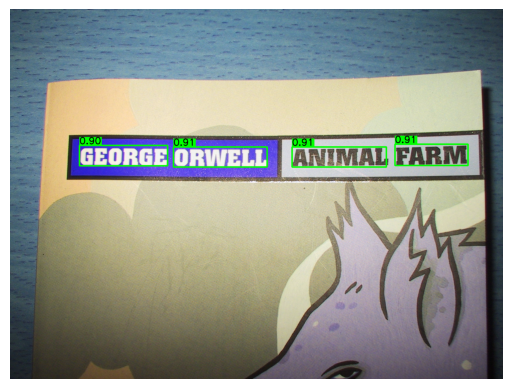

In [33]:
from ultralytics import YOLO

model_path = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\models\\yolov8\\detect\\train\\weights\\best.pt'
img_path = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\SceneTrialTrain\\apanar_06.08.2002\\IMG_1259.JPG'
conf_thres = 0.75

model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].tojson())
print(predictions[0])
visulized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visulized_img)
plt.axis('off')
plt.show()